<a href="https://colab.research.google.com/github/mirklys/little-projects/blob/main/thesis/data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch as th
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
import copy
from collections import defaultdict
import seaborn as sns
from collections import Counter


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
PATH_BASE = '/content/gdrive/MyDrive/Thesis Project'
PATH_DATA = os.path.join(PATH_BASE, 'data/')
PATH_NETWORKS = os.path.join(PATH_BASE, 'networks/')
PATH_PLOTS = os.path.join(PATH_BASE, 'plots/')
PATH_RESULTS = os.path.join(PATH_BASE, 'results/')
PATH_LOGS = os.path.join(PATH_BASE, 'logs/')
os.chdir(PATH_BASE)

In [ ]:
def smooth(scalars: np.ndarray, weight: float) -> np.ndarray:  # smoothen the means
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point 
        smoothed.append(smoothed_val)         
        last = smoothed_val                                 

    return np.array(smoothed)

In [ ]:
def perf_rew_plot(data: dict, game: str):
    plt.rcParams.update({'errorbar.capsize': 5, 'font.size': 12, 'font.family': 'Times New Roman'})
    colors = plt.cm.plasma(np.linspace(0, 1, 10))
    plt.style.use('seaborn')
    fig, ax = plt.subplots(2, 2, figsize=(18,9), sharex=True, sharey=True)
    binary = lambda x: bin(x).replace("0b", "")
    for i, (size, v) in enumerate(data.items()):
        ib = binary(i)
        if len(ib) == 1: ib = "0"+ib
        j, k = tuple([int(x) for x in ib])
        for d, color in zip(v, colors):
            dropout, x, mean_rew, std_rew = d[0], d[1], d[2], d[3]
            dropout = dropout[0]
            ste_rew = np.array(std_rew)/np.sqrt(len(std_rew)) # calculating standard error
            smoothed_mean = smooth(mean_rew, .8)
            smoothed_ste = smooth(ste_rew, .8)

            ax[j, k].fill_between(np.array(x)*100, smoothed_mean-smoothed_ste, smoothed_mean+smoothed_ste, color=color, alpha=.25)
            ax[j, k].plot(np.array(x)*100, smoothed_mean, color=color, label="{}% dropout".format(int(dropout*100)), linewidth=3)

        if k == 0: ax[j, k].set_ylabel("average cumulative reward")
        if j == 1: ax[j, k].set_xlabel("mask size, %")
        title = "MLP policy network of size {}x{}".format(size, size)
        ax[j, k].set_title(title, fontsize=12, y=.98, fontname="sans-serif", fontweight="bold", pad=15)
        ax[j, k].legend(loc="best")
    fig.tight_layout(rect=[0, 0, .9, 1])
    plt.savefig(os.path.join(PATH_PLOTS,game,'different_model_sizes_performance'+".png"))

In [ ]:
def parse_file_name(file: str) -> tuple:
    splitted = file.split(".")
    game = splitted[0]
    size = splitted[1].split("x")[0]
    dropout = float(file.replace("{}.{}x{}.dropout".format(game, size, size), "")[1:][:-7])
    return game, int(size), dropout

In [ ]:
def load(path: str, size:bool=False, dropout:bool=False) -> dict: # size|dropout: [[dropout|size,...], [x,...], [mean,...], [std,...]]
    assert size ^ dropout # must be stored as either size or dropout as a key
    data = defaultdict(list)
    loaded = pickle.load(open(path, 'rb'))
    x = np.arange(0., 1.05, .05, dtype=float)
    for (game, net_size, dt), v in loaded.items():
        dt = round(dt, 1)
        net_size = int(net_size)
        v = np.transpose([list(x) for x in v])
        rew, std = v[0], v[1]
        if size: data[net_size].append(np.array([[dt]*len(x), x, rew, std]))
        elif dropout: data[dt].append(np.array([[net_size]*len(x), x, rew, std]))
    return data

In [ ]:
def take_single_reward(data, size, dropout, mask)->tuple:
    data = data[size]
    for dropout_dir in data:
        dt = dropout_dir[0][0]
        dropout = round(dropout, 2)
        dt = round(dt, 2)
        if dt == dropout:
            where = np.argwhere(dropout_dir[1]==mask)[0]
            if type(where) == np.ndarray: where = where[0]
            return dropout_dir[2][where], dropout_dir[3][where]
    return (None,)

In [ ]:
def retrieve(data_size, size, dropout, mask)->pd.DataFrame:
    retrieved_info = defaultdict(list)
    info = []
    for s in size:
        for d in dropout:
            for m in mask:
                rtvr = take_single_reward(data_size, s, d, m)
                if rtvr != (None,):
                    reward, std = rtvr
                    info.append([s, round(d, 2), m, reward, std])

    info = np.transpose(info)
    retrieved_info['size'] = info[0].astype(int)
    retrieved_info['dropout'] = info[1]
    retrieved_info['mask'] = info[2]
    retrieved_info['mean'] = info[3]
    retrieved_info['std'] = info[4]
    retrieved_info = pd.DataFrame(retrieved_info)
    retrieved_info = retrieved_info.sort_values(['size', 'dropout', 'mask'], ascending=[True, True, True])
    return retrieved_info

In [ ]:
carpole_data_size = load(os.path.join(PATH_RESULTS, 'evals_cartpole.pickle'), size=True)

In [ ]:
retrieved_mask_0 = retrieve(carpole_data_size, size=carpole_data_size.keys(), dropout=np.arange(0, 1, 0.05), mask=[0])

In [ ]:
retrieved_mask_0.to_excel("retrieved_mask_0_cartpole.xlsx") 

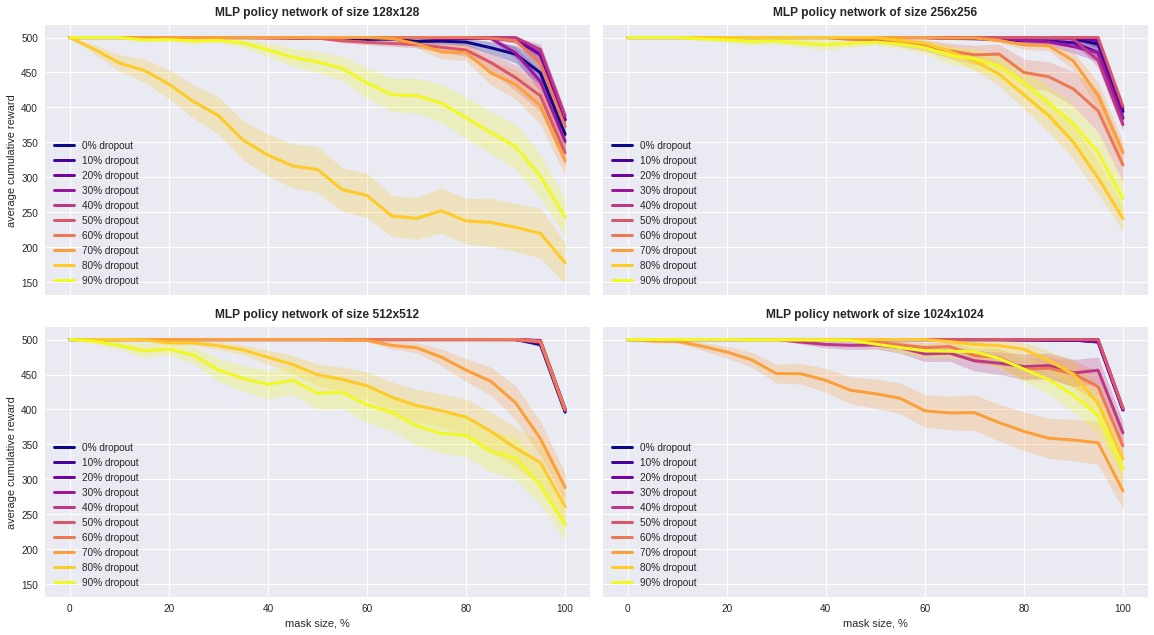

In [ ]:
perf_rew_plot(carpole_data_size, 'cartpole')

In [ ]:
def parse_title(title: str) -> tuple:
    splitted = title.split(".")
    game = splitted[0]
    size = splitted[1].split("x")[0]
    dropout = float(title.split("_")[1])
    return game, size, dropout

In [ ]:
def parser_masked_title(name: str) -> tuple:
    # CartPole-v1.128x128.dropout_0.8.mask_0.25.overtrained
    splitted = name.split('.')
    game = splitted[0]
    size = splitted[1].split("x")[0]
    split_underscore = name.split('_') #CartPole-v1.128x128.dropout, 0.8.mask, 0.25.overtrained
    dropout = split_underscore[1].replace('.mask', '')
    mask = split_underscore[2].replace('.overtrained', '')
    return game, size, float(dropout), float(mask)

In [ ]:
def load_further_trained_data(path_f: str) -> dict: # (size, dropout): mask, (rew, std, steps)
    data = defaultdict(list)
    loaded_f = pickle.load(open(path_f, 'rb'))

    for name, vals in loaded_f.items():
        game, size, dropout, mask = parser_masked_title(name)
        (rew, std, steps) = vals[0]
        data[int(size), dropout].append((mask, rew, std, steps))

    return data

In [ ]:
def to_np(array):
    """
    I just shorted np.array(array), otherwise, the code would be to messy in my opinion
    """
    return np.array(array)

In [ ]:
def concat_originial_further_trained_data(data_f, data_n_size) -> dict: # (size, dropout): ([masks], [rew_original], [std_original], [rew_masked], [std_masked], [steps])
    data_concat = defaultdict(list)
    """
        data_n -- size|dropout: [[dropout|size,...], [x,...], [mean,...], [std,...]]
    """
    for size, v in data_n_size.items():
        for val in v:
            dropout, x, mean_reward, std_reward = tuple(val)
            if type(dropout) == list or type(dropout) == np.ndarray: d = dropout[0]
            else: d = dropout
            mean_reward_masked = mean_reward.copy()
            std_reward_masked = std_reward.copy()
            steps = [0]*len(x)
            eval_f = data_f[size, d]
            for (mask, rew, std, step) in eval_f:
                indx = np.where(x==mask)
                indx=indx[0][0]
                mean_reward_masked[indx] = rew
                std_reward_masked[indx] = std
                steps[indx] = step
            data_concat[size, d] = [to_np(x), to_np(mean_reward), to_np(std_reward), to_np(mean_reward_masked), to_np(std_reward_masked), to_np(steps)]

    return data_concat

In [ ]:
carpole_data_f = load_further_trained_data(os.path.join(PATH_RESULTS, 'evaluations_overtrained_cartpole.pickle'))
data_f_o = concat_originial_further_trained_data(carpole_data_f, carpole_data_size)

In [ ]:
def rew_differences(data, size=128):
    diff = defaultdict(list)
    for k, v in data.items():
        s, d = k
        x, mean_reward, std_reward, mean_reward_masked, std_reward_masked, steps = tuple(v)
        if s == size:
            together = list(zip(mean_reward, mean_reward_masked, x, steps))
            dif = [[s, k, n-m, n>=m*0.97] for (m, n, s, k) in together if m > 0 and n > 0]
            mean_reward = to_np(mean_reward)
            mean_reward_masked = to_np(mean_reward_masked)
            diff[d].append(np.transpose(dif))

    return diff

In [ ]:

def weights(data):
    pairs = list(zip(data[0], data[1]))
    counted = Counter(pairs)
    counts = [counted[pair] for pair in pairs]
    return np.array(counts)


In [ ]:
def plot_differences(data, game='cartpole', scale=8):
    achieved_capacity = {}
    plt.rcParams.update({'errorbar.capsize': 5, 'font.size': 12, 'font.family': 'Times New Roman'})
    colors = plt.cm.plasma(np.linspace(0, 1, 10))
    plt.style.use('seaborn')
    # i don't think it is included in the report
    fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(18, 9))
    #fig.sutitle("Steps taken to regain a maximum performance of 500 for models trained at \n different dropout rates after applying an increasing masking size", y=1.07)
    binary = lambda x: bin(x).replace("0b", "")
    for i, size in enumerate([128, 256, 512, 1024]):
        ib = binary(i)
        if len(ib) == 1: ib = "0"+ib
        j, k = tuple([int(x) for x in ib])
        diff = rew_differences(data, size=size)
        for color, (dropout, v) in zip(colors, diff.items()):
            #print(v)
            v = to_np(v[0])
            achieved_capacity[size, dropout] = v[-1]
            weight = v[1] + 0.1
            ax[j, k].scatter(v[0]*100, v[2], label="{}% dropout".format(dropout*100), color=color, s=weight*scale)
        ax[j, k].set_title("model size {}x{}".format(size, size))
        #ax[j, k].legend()
        if k == 0: ax[j, k].set_ylabel("performance increment")
        if j == 1: ax[j, k].set_xlabel("mask size, %")
    fig.tight_layout(rect=[0, 0, .9, 1])
    handles, labels = plt.gca().get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right', prop={'size': 12}, labelspacing=1, borderpad=1)
    plt.savefig(os.path.join(PATH_PLOTS,game,'differences_performance_overtrained'+".png"))
    return achieved_capacity

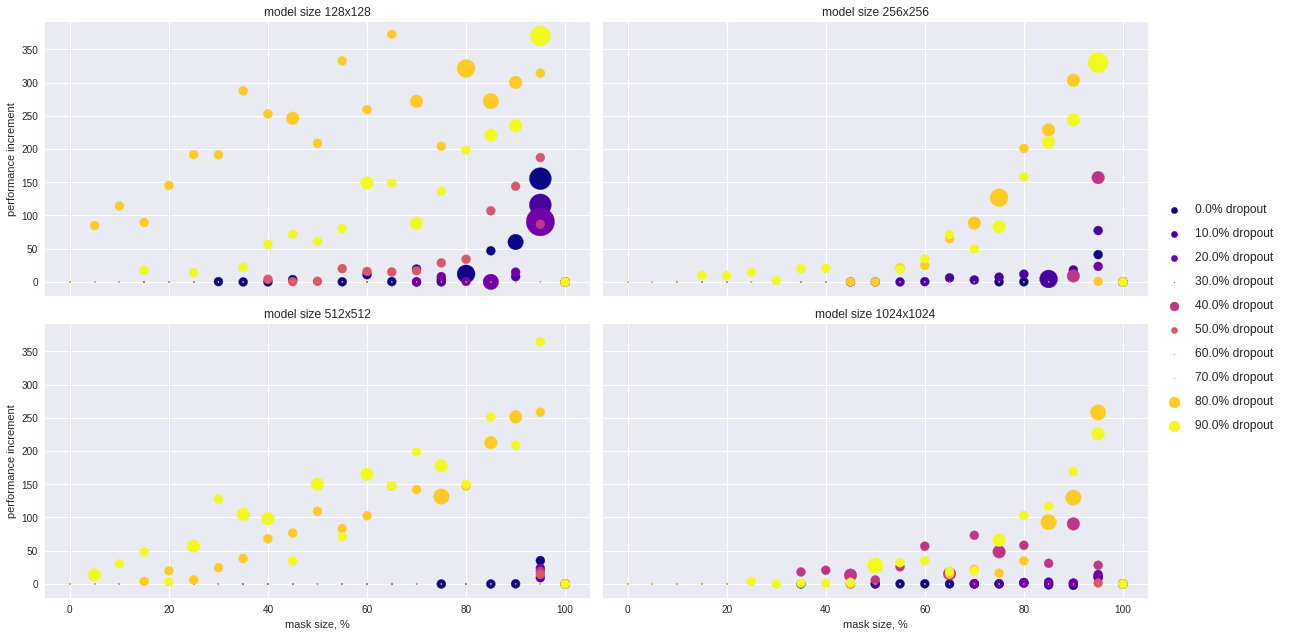

In [ ]:
full_capacity = plot_differences(data_f_o, game='cartpole', scale=8)

In [ ]:
def fullness(data):
    for (s, d), full in data.items():
        data[s, d] = np.sum(full)
    return data

In [ ]:
full_capacity_cartpole = fullness(full_capacity)

In [ ]:
full_capacity_cartpole

{(128, 0.0): 21.0,
 (128, 0.1): 21.0,
 (128, 0.2): 21.0,
 (128, 0.3): 21.0,
 (128, 0.4): 21.0,
 (128, 0.5): 21.0,
 (128, 0.6): 21.0,
 (128, 0.7): 21.0,
 (128, 0.8): 21.0,
 (128, 0.9): 21.0,
 (256, 0.0): 21.0,
 (256, 0.1): 21.0,
 (256, 0.2): 21.0,
 (256, 0.3): 21.0,
 (256, 0.4): 21.0,
 (256, 0.5): 21.0,
 (256, 0.6): 21.0,
 (256, 0.7): 21.0,
 (256, 0.8): 21.0,
 (256, 0.9): 21.0,
 (512, 0.0): 21.0,
 (512, 0.1): 21.0,
 (512, 0.2): 21.0,
 (512, 0.3): 21.0,
 (512, 0.4): 21.0,
 (512, 0.5): 21.0,
 (512, 0.6): 21.0,
 (512, 0.7): 21.0,
 (512, 0.8): 21.0,
 (512, 0.9): 21.0,
 (1024, 0.0): 21.0,
 (1024, 0.1): 21.0,
 (1024, 0.2): 21.0,
 (1024, 0.3): 21.0,
 (1024, 0.4): 21.0,
 (1024, 0.5): 21.0,
 (1024, 0.6): 21.0,
 (1024, 0.7): 21.0,
 (1024, 0.8): 21.0,
 (1024, 0.9): 21.0}

In [ ]:
def steps(data:dict, size=128) -> np.ndarray:
    mean_steps = []

    for k, v in data.items():
        s, d = k
        steps = v[-1]
        if s == size: mean_steps.append(steps)
        
    return np.array(mean_steps)

In [ ]:
plt.rcParams.update({'errorbar.capsize': 5, 'font.size': 12, 'font.family': 'Times New Roman'})
colors = plt.cm.plasma(np.linspace(0, 1, 10))
plt.style.use('seaborn')
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(18, 9))
#fig.suptitle("Steps taken to regain a maximum performance of 500 for models trained at \n different dropout rates after applying an increasing masking size", y=1.07)
binary = lambda x: bin(x).replace("0b", "")
cbar_ax = fig.add_axes([.91, .3, .03, .4])
for i, size in enumerate([128, 256, 512, 1024]):
    ib = binary(i)
    if len(ib) == 1: ib = "0"+ib
    j, k = tuple([int(x) for x in ib])
    sns.heatmap(ax=ax[j, k], data=steps(data_f_o, size=size), cmap="YlGnBu", cbar=i==0, cbar_ax=None if i else cbar_ax)
    ax[j, k].set_yticklabels([0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
    ax[j, k].set_xticklabels(np.arange(0, 105, 5))
    ax[j, k].set_title("model size {}x{}".format(size, size))
    if k == 0: ax[j, k].set_ylabel("dropout, %")
    if j == 1: ax[j, k].set_xlabel("mask size, %")

fig.tight_layout(rect=[0, 0, .9, 1])
plt.savefig(os.path.join(PATH_PLOTS,'cartpole',"recovery.png"))
plt.show()

In [ ]:
files_result = os.listdir(PATH_RESULTS)
lunar_lander_eval_files = [x for x in files_result if x.startswith('evals_LunarLander')]
lunar_lander_overtrained_eval_files = [x for x in files_result if x.startswith('overtrained_evals_LunarLander')]

In [ ]:
lunar_lander_eval = [] # [name, rew, std, total_further_train_steps] name: game.sxs.dropout_d.mask_m.overtrained
lunar_lander_overtrained_eval = [] # [game, size, dropout, mean_rews, std_rews]
for filename in lunar_lander_eval_files:
    with open(os.path.join(PATH_RESULTS, filename), 'rb') as f:
        lunar_lander_eval.append(pickle.load(f))

for filename in lunar_lander_overtrained_eval_files:
    with open(os.path.join(PATH_RESULTS, filename), 'rb') as f:
        lunar_lander_overtrained_eval.append(pickle.load(f))

In [ ]:
def overtrained_name_parser(name: str) -> tuple:
    by_dot = name.split('.')
    game = by_dot[0]
    size = by_dot[1].split('x')[0]
    by_underscore = name.split('_')
    dropout = by_underscore[1][:-5]
    mask = by_underscore[2][:-12]

    return game, int(size), round(float(dropout), 1), round(float(mask), 2)

In [ ]:
# size|dropout: [[dropout|size,...], [x,...], [mean,...], [std,...]]

lunar_lander_eval_dict = defaultdict(list)
t2 = defaultdict(list)
for t1 in lunar_lander_eval:
    for masking in t1:
        game = masking[0]
        size = masking[1]
        dropout = masking[2]
        mean_reward = masking[3]
        std_reward = masking[4]
        length = len(mean_reward)
        lunar_lander_eval_dict[size].append([[dropout]*length, np.arange(0, 1, 0.05), mean_reward, std_reward])
        t2[int(size), round(float(dropout), 1)].append(np.transpose([np.arange(0, 1, 0.05), mean_reward, std_reward]))

for size, masking in lunar_lander_eval_dict.items():
    masking = sorted(masking, key=lambda x: x[0][0])
    lunar_lander_eval_dict[size] = masking

In [ ]:
retrieved_lunarlander_mask_0 = retrieve(lunar_lander_eval_dict, size=lunar_lander_eval_dict.keys(), dropout=np.arange(0, 1, 0.05), mask=[0])

In [ ]:
retrieved_lunarlander_mask_0.to_excel("retrieved_lunarlander_mask_0.xlsx") 

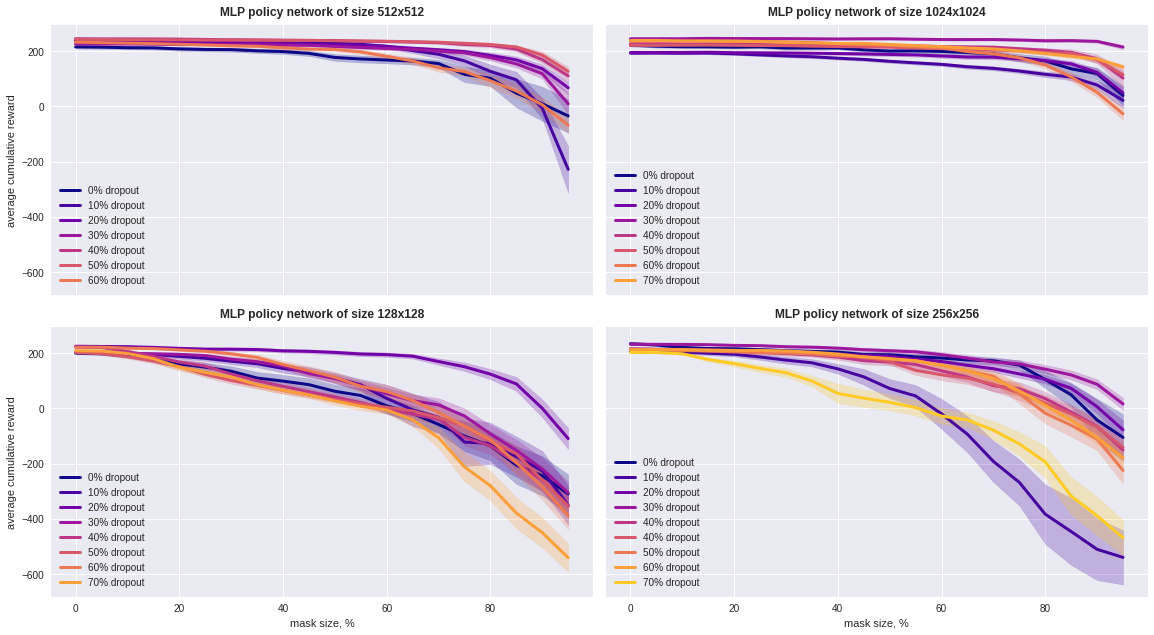

In [ ]:
perf_rew_plot(lunar_lander_eval_dict, 'LunarLander-v2')

In [ ]:
lunar_lander_overtrained_eval_dict = defaultdict(tuple) # (size, dropout): ([masks], [rew_original], [std_original], [rew_masked], [std_masked], [steps])

In [ ]:
#(size, dropout): mask, (rew, std, steps)
mask_rate = np.arange(0, 1, 0.05)


In [ ]:
t_dict = defaultdict(list)
for batch in lunar_lander_overtrained_eval:
    for masked in batch:
        game, size, dropout, mask = overtrained_name_parser(masked[0])
        mean_reward = masked[1]
        std_reward = masked[2]
        step = masked[3]
        t_dict[size, dropout].append([mask, mean_reward, std_reward, step])

In [ ]:
def find_list_at_dropout(original, dropout):
    for vals in original:
        if round(vals[0][0], 2) == round(dropout, 2):
            return vals

In [ ]:
# size: [[dropouts.. same value], [masks], [means], [stds]] --> lunar_lander_eval_dict original
# (size, dropout): [mask, mean_rew, std, step]--> t_dict overtrained
# (size, dropout): ([masks], [rew_original], [std_original], [rew_masked], [std_masked], [steps]) --> to make
for key in t_dict:
    size, dropout = key
    original = lunar_lander_eval_dict[str(size)] # lists of [[dropouts.. same value], [masks], [means], [stds]] 
    if original: 
        original_dropout = find_list_at_dropout(original, dropout) # so we have an original performance of size and dropout of the key
        dropouts, masks, means, stds = tuple(original_dropout)
        means_further = means.copy()
        stds_further = stds.copy()
        steps_further = [0]*len(means_further) 
        for further in t_dict[key]:
            mask, mean_rew, std, step = tuple(further)
            idx = np.where(masks>=mask)[0][0]
            means_further[idx] = mean_rew
            stds_further[idx] = stds
            steps_further[idx] = step

        lunar_lander_overtrained_eval_dict[size, dropout] = masks, means, stds, means_further, stds_further, steps_further
    else: continue

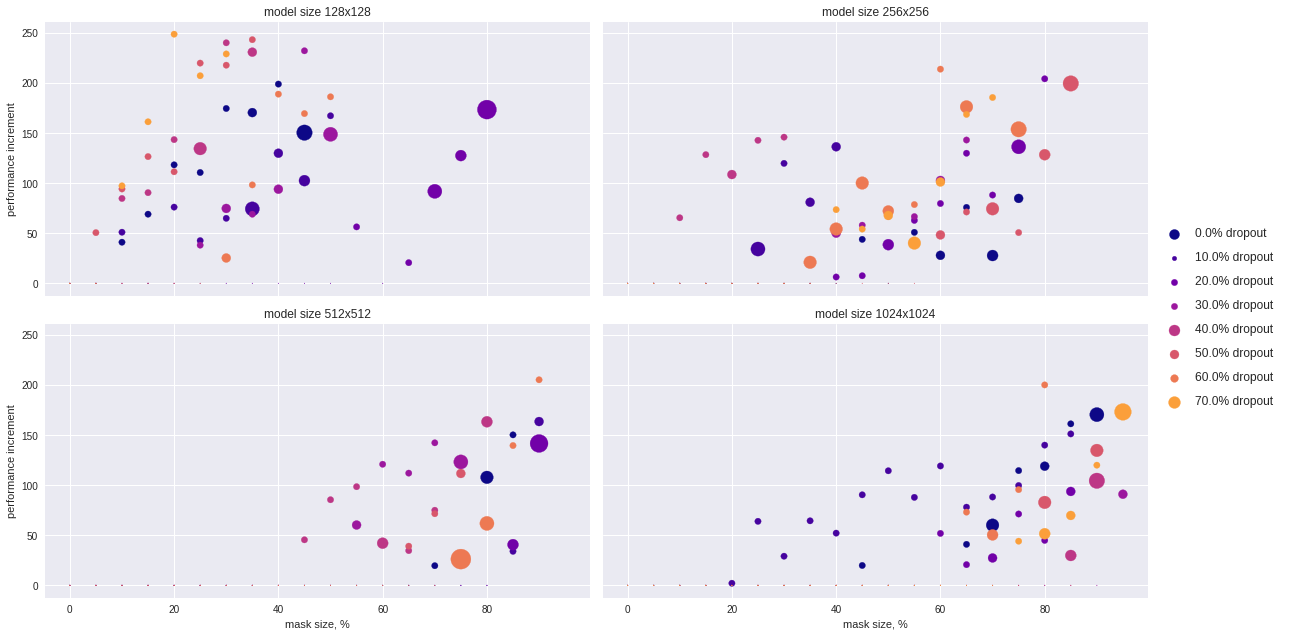

In [ ]:
full_capacity = plot_differences(lunar_lander_overtrained_eval_dict, game='LunarLander-v2', scale=4)
full_capacity_lunarlander = fullness(full_capacity)

In [ ]:
full_capacity_lunarlander

{(128, 0.0): 10.0,
 (128, 0.1): 11.0,
 (128, 0.2): 17.0,
 (128, 0.3): 11.0,
 (128, 0.4): 8.0,
 (128, 0.5): 8.0,
 (128, 0.6): 11.0,
 (128, 0.7): 7.0,
 (256, 0.0): 16.0,
 (256, 0.1): 9.0,
 (256, 0.2): 17.0,
 (256, 0.3): 18.0,
 (256, 0.4): 15.0,
 (256, 0.5): 15.0,
 (256, 0.6): 14.0,
 (256, 0.7): 7.0,
 (512, 0.0): 16.0,
 (512, 0.1): 16.0,
 (512, 0.2): 19.0,
 (512, 0.3): 18.0,
 (512, 0.4): 19.0,
 (512, 0.5): 19.0,
 (512, 0.6): 16.0,
 (1024, 0.0): 19.0,
 (1024, 0.1): 18.0,
 (1024, 0.2): 18.0,
 (1024, 0.3): 20.0,
 (1024, 0.4): 19.0,
 (1024, 0.5): 19.0,
 (1024, 0.6): 17.0,
 (1024, 0.7): 20.0}

In [ ]:
plt.rcParams.update({'errorbar.capsize': 5, 'font.size': 12, 'font.family': 'Times New Roman'})
colors = plt.cm.winter(np.linspace(0, 1, 10))
plt.style.use('seaborn')
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(18, 9))
#fig.suptitle("Steps taken to regain a maximum performance of 500 for models trained at \n different dropout rates after applying an increasing masking size", y=1.07)
binary = lambda x: bin(x).replace("0b", "")
cbar_ax = fig.add_axes([.91, .3, .03, .4])
for i, size in enumerate([128, 256, 512, 1024]):
    ib = binary(i)
    if len(ib) == 1: ib = "0"+ib
    j, k = tuple([int(x) for x in ib])
    sns.heatmap(ax=ax[j, k], data=steps(t2, size=size), cmap="YlGnBu", cbar=i==0, cbar_ax=None if i else cbar_ax)
    ax[j, k].set_yticklabels([0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
    ax[j, k].set_xticklabels(np.arange(0, 105, 5))
    ax[j, k].set_title("model size {}x{}".format(size, size))
    if k == 0: ax[j, k].set_ylabel("dropout, %")
    if j == 1: ax[j, k].set_xlabel("mask size, %")

fig.tight_layout(rect=[0, 0, .9, 1])
plt.savefig(os.path.join(PATH_PLOTS,'LunarLander-v2',"recovery.png"))
plt.show()